# News Events

**Purpose:** Compare outlet leadership within multi-article news events.

**Steps:**
1. Load/filter dataframe of multi-article clusters
2. Make dyads per cluster
3. Filter dyads per cluster
4. Shift from cluster-level to dyad-level
5. Comparisons

**Note:** Each outlet is associated one-to-one with a `doctype`. Each `doctype` is categorized under a `doctype_ideo` value, which is either "alternative-right" or "established-right".

In [1]:
import os
from pprint import pprint

In [2]:
%matplotlib inline

In [3]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '06-dyadic-comparison', logger_type='main')

In [4]:
df_dir = os.path.join("..", "..", "data", "02-intermediate", "06-newsevents", "05-softcosine-clusters", "dataframes")

In [5]:
from usrightmedia.shared.clusters_utils import *

2021-11-22 22:58:10,741 - [WARNING] - INCA - (hype_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?
2021-11-22 22:58:10,746 - [WARNING] - INCA - (var_tsa_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?


<hr>

## Full version

### 1. Load dataframe of multi-article clusters
- Select the softcosine threshold whose clusters represent news events
- Add columns for:
    - `doctype`: corresponds with the outlet names
    - `doctype_ideo`: "est" ("established right") or "alt" ("alternative right")
    - `doc_topic`: the primary topic assigned to the document per topic modeling
    - `doc_tw`: the doc's URL was tweeted or re-tweeted by a congressional Republican who served any time during 2016 - 2020
- `rmv_docs_with_odd_publish_date_ind=True`: remove documents published at exactly 05:00 UTC (midnight EST)
- Filter for selected year(s) and topic(s). If the corresponding value(s) is an empty list, no filtering is used and all documents are kept in the dataset.

In [6]:
%%time
df_clusters = load_multi_doc_clusters_only(df_dir, "softcos06")
df_clusters["doctype"] = df_clusters["doc_id"].map(lambda d: extract_doctype(d))
df_clusters["doctype_ideo"] = df_clusters["doctype"].map(lambda d: get_ideo_subcategory(d))

# more efficient to query all doc_ids together than to send an HTTP request to ES for each doc_id.
# store the retrieved data in a helper dataframe (df_topics, df_tw) which is then used to populate df_clusters.

# TODO
# df_topic = get_field_value_for_ids(list(df_clusters["doc_id"]), "topic")
# df_clusters["doc_topic"] = df_clusters["doc_id"].map(lambda d: df_topic.at[d, "topic"])
df_clusters["doc_topic"] = df_clusters["doc_id"].map(lambda d: get_doc_topic(d)) # placeholder values

df_tw = get_field_value_for_ids(list(df_clusters["doc_id"]), "tweets2_url_ids")
df_clusters["doc_tw"] = df_clusters["doc_id"].map(lambda d: df_tw.at[d, "tweets2_url_ids"])

df_clusters_filtered = filter_clusters(
                            df_clusters,
                            rmv_docs_with_odd_publish_date_ind=True,
                            filters={"years": [],
                                     "topics": []}
                        )

100%|██████████| 46798/46798 [00:33<00:00, 1387.89it/s]


CPU times: user 1min 42s, sys: 1.85 s, total: 1min 44s
Wall time: 2min 6s


### 2. Make dyads per cluster
- A cluster can consist of 0 or more dyads.
    - The dyad list is empty if only 1 document remained after the filters above.
    - The dyad list contains 1+ dyads if there were at least 2+ documents remaining in the cluster.
    
- For each dyad:
    - The first position is occupied by the doctype (i.e., outlet) which publishes the oldest article within the cluster.
    - The second position is occupied by a doctype which publishes a subsequent article within the cluster.
    
- `dyads`: two-item tuple where each item is a dict. Each dict represents a document.
- `dyads_cx`: dictionary where the key is the `cluster_id` and the value is the list of dyads associated with it.
- `dyads_cid`: the dyads for one cluster

In [7]:
%%time
dyads_cx = get_clusters_as_dyads(df_clusters_filtered)

CPU times: user 49.2 s, sys: 176 ms, total: 49.3 s
Wall time: 49.3 s


### 3. Filter dyads per cluster

`keep_dyads_bn_diff_doctypes_only=True`: 
- If the second outlet is the same as the first outlet, then the dyad is excluded.
- Example, 4-article news event:
    - Breitbart publishes the 1st article (D1)
    - Fox News publishes the 2nd article (D2)
    - Breitbart publishes the 3rd outlet (D3)
    - Daily Stormer publishes the 4th outlet (D4)
- Result:
    - D1-D2: included
    - D1-D3: excluded (same outlet in the first and second positions of the dyad)
    - D1-D4: included
    
`keep_first_doctype_pair_only=True`:
- Only the first instance of a doctype pair is kept.
- Example, 3-article news event:
    - Newsmax publishes the 1st article (D1)
    - One America News publishes the 2nd article (D2)
    - One America News publishes the 3rd article (D3)
- Result:
    - D1-D2: included
    - D1-D3: excluded (repeat of "newsmax-oneamericanews" pair)

In [8]:
%%time
dyads_cx_filtered = filter_dyads(dyads_cx,
                                 keep_dyads_bn_diff_doctypes_only=True,
                                 keep_first_doctype_pair_only=True)

CPU times: user 3.77 s, sys: 264 ms, total: 4.04 s
Wall time: 4.03 s


### 4. Shift from cluster-level to dyad-level

In [9]:
%%time
dyads_filtered = extract_dyads(dyads_cx_filtered)

CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 1.71 ms


### 5. Comparisons
- In the comparison tables, the doctype (i.e., outlet) in the row is the leader and the doctype in the column is the follower.

#### 5.1 Dyadic comparisons

![dyadic comparison](https://raw.githubusercontent.com/wlmwng/us-right-media/develop/usrightmedia/figures/dyadic_comparison.svg?token=AFRZSYUKYSPHLQKR4U45Z33BUSEIG)

In [10]:
# spot-check the cells in dyadic_count_doctype
matched = get_matched_dyads(dyads=dyads_filtered,
                      d0_key="doctype",
                      d1_key="doctype",
                      d0_values=["dailycaller"],
                      d1_values=["newsmax"])

len(matched)

199

To calculate the total number of dyads that an outlet participates in: <br>
`dyadic_count_doctype.at[DOCTYPE, "All"] + dyadic_count_doctype.at["All", DOCTYPE]`

In [11]:
dyadic_count_doctype = make_dyadic_comparison(dyads=dyads_filtered, key="doctype", version="count")
dyadic_count_doctype

,All,americanrenaissance,breitbart,dailycaller,dailystormer,foxnews,gatewaypundit,infowars,newsmax,oneamericanews,rushlimbaugh,seanhannity,vdare,washingtonexaminer
All,14854,406,3181,2474,322,2491,1033,984,1573,805,81,194,151,1159
americanrenaissance,71,0,17,12,7,11,3,3,2,3,0,0,10,3
breitbart,2472,112,0,524,92,531,253,297,212,126,16,44,38,227
dailycaller,2479,49,724,0,38,591,214,192,199,94,17,37,25,299
dailystormer,75,12,25,13,0,5,3,6,6,2,0,0,2,1
foxnews,3671,91,973,875,64,0,253,188,510,302,21,46,30,318
gatewaypundit,871,21,221,162,19,150,0,112,52,15,9,21,7,82
infowars,362,16,112,58,3,64,41,0,21,10,0,7,11,19
newsmax,1288,14,290,211,22,341,69,34,0,185,1,8,9,104
oneamericanews,1665,27,355,202,26,450,31,86,364,0,3,9,11,101


In [12]:
dyadic_prop_doctype = make_dyadic_comparison(dyads=dyads_filtered, key="doctype", version="proportion")
# displays as percentages
dyadic_prop_doctype.round(decimals=3).select_dtypes(include=["number"])*100

,All,americanrenaissance,breitbart,dailycaller,dailystormer,foxnews,gatewaypundit,infowars,newsmax,oneamericanews,rushlimbaugh,seanhannity,vdare,washingtonexaminer
All,50.0,85.1,56.3,49.9,81.1,40.4,54.3,73.1,55.0,32.6,68.6,79.2,52.4,40.9
americanrenaissance,14.9,0.0,13.2,19.7,36.8,10.8,12.5,15.8,12.5,10.0,0.0,0.0,18.9,13.0
breitbart,43.7,86.8,0.0,42.0,78.6,35.3,53.4,72.6,42.2,26.2,47.1,77.2,63.3,35.6
dailycaller,50.1,80.3,58.0,0.0,74.5,40.3,56.9,76.8,48.5,31.8,89.5,80.4,61.0,43.4
dailystormer,18.9,63.2,21.4,25.5,0.0,7.2,13.6,66.7,21.4,7.1,0.0,0.0,6.1,5.0
foxnews,59.6,89.2,64.7,59.7,92.8,0.0,62.8,74.6,59.9,40.2,77.8,82.1,83.3,49.4
gatewaypundit,45.7,87.5,46.6,43.1,86.4,37.2,0.0,73.2,43.0,32.6,60.0,67.7,87.5,35.5
infowars,26.9,84.2,27.4,23.2,33.3,25.4,26.8,0.0,38.2,10.4,0.0,100.0,64.7,24.1
newsmax,45.0,87.5,57.8,51.5,78.6,40.1,57.0,61.8,0.0,33.7,100.0,61.5,47.4,35.1
oneamericanews,67.4,90.0,73.8,68.2,92.9,59.8,67.4,89.6,66.3,0.0,75.0,100.0,100.0,60.1


In [13]:
dyadic_count_ideo = make_dyadic_comparison(dyads=dyads_filtered, key="doctype_ideo", version="count")
dyadic_count_ideo

,All,alt,est
All,14854,8455,6399
alt,6941,3528,3413
est,7913,4927,2986


#### 5.2 Dyadic comparisons over time

In [14]:
# run this cell if the plots don't show inline
%matplotlib inline

In [15]:
# Run this cell if the following RuntimeWarning shows up

# RuntimeWarning: More than 20 figures have been opened.
# Figures created through the pyplot interface (matplotlib.pyplot.figure) are retained
# until explicitly closed and may consume too much memory.

# import matplotlib.pyplot as plt
# plt.close('all')

- The figure aggregates the dyads between right-wing alternative and established media over 2016-2020. Each category-pair is directional. For example, `alt_est` represents a dyad where an alternative outlet was the first to cover a news event which was later adopted by an established outlet. The percentages sum to 100% across the category-pairs per year, and indicate alternative and established outlets' relative resonance within the right-wing media sphere.

- When considering all dyads, alternative-right outlets lead (alt_alt + alt_est)% of the time and established-right outlets lead (est_alt + est_est) of the time.

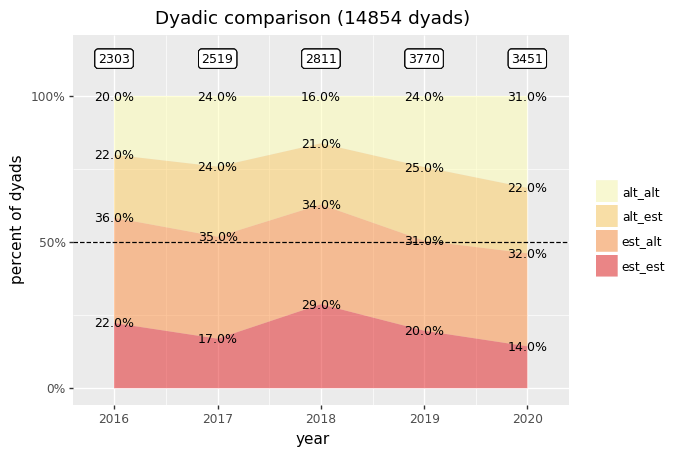

<ggplot: (8787705255165)>

In [16]:
# effectively no filter is applied since all doctypes are included
# the function returns two plots (one for each direction)
# in this case, the two plots are identical so just show idx 0
plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                       key0="doctype",
                                       key1="doctype",
                                       values0=DOCTYPES,
                                       values1=DOCTYPES)[0]

- compare selected established-right outlets based on their patterns as followers

In [39]:
# spot-check the yearly dyadic comparison
matched = get_matched_dyads(dyads=dyads_filtered,
                      d0_key="doctype_ideo",
                      d1_key="doctype",
                      d0_values=["alt", "est"],
                      d1_values=["foxnews"])

print(f"matched: {len(matched)} dyads")
print(f"matched per year: {sorted(Counter([m[0]['doc_publish_date'].year for m in matched]).items())}")

matched: 2491 dyads
matched per year: [(2016, 322), (2017, 412), (2018, 445), (2019, 706), (2020, 606)]


------------------------------------------------------------------------------------------------------------------------
When ['foxnews'] is a follower, it follows alternative-right outlets (alt_est)% of the time and established-right outlets (est_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype_ideo(s): ['alt', 'est']
Following doctype(s): ['foxnews']


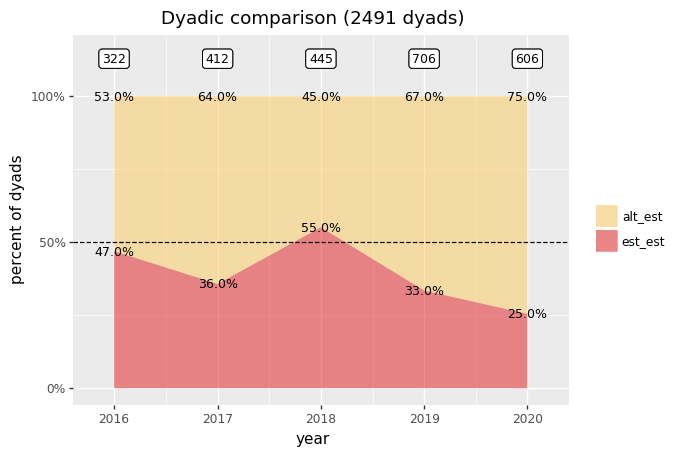

<ggplot: (8787717001991)>

------------------------------------------------------------------------------------------------------------------------
When ['washingtonexaminer'] is a follower, it follows alternative-right outlets (alt_est)% of the time and established-right outlets (est_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype_ideo(s): ['alt', 'est']
Following doctype(s): ['washingtonexaminer']


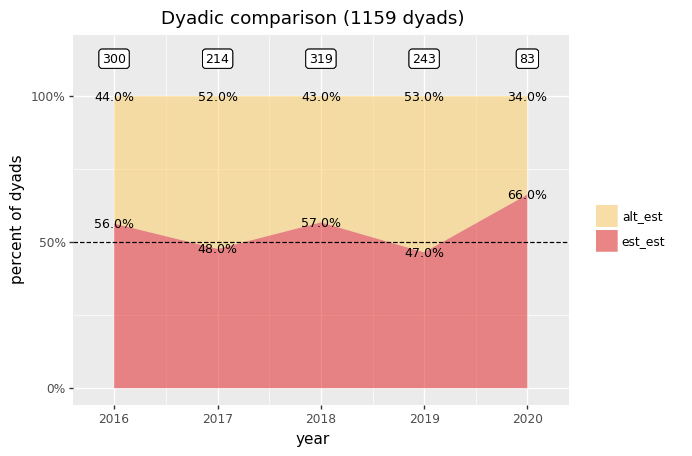

<ggplot: (8787714152271)>

In [17]:
for DOCTYPE in ["foxnews", "washingtonexaminer"]:
    KEY0 = "doctype"
    KEY1 = "doctype_ideo"
    VALUES0 = [DOCTYPE]
    DOCTYPE0_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==VALUES0[0]]["ideo_subcategory"])[0]]
    VALUES1 = ["alt", "est"]

    plots = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                           key0=KEY0,
                                           key1=KEY1,
                                           values0=VALUES0,
                                           values1=VALUES1)

    # print("-"*120)
    # print(f"When {VALUES0} is a leader, it leads alternative-right outlets ({DOCTYPE0_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE0_IDEO}_est)% of the time.")
    # print("-"*120)
    # print(f"Leading {KEY0}(s): {VALUES0}")
    # print(f"Following {KEY1}(s): {VALUES1}")
    # display(plots[0])

    print("-"*120)
    print(f"When {VALUES0} is a follower, it follows alternative-right outlets (alt_{DOCTYPE0_IDEO})% of the time and established-right outlets (est_{DOCTYPE0_IDEO})% of the time.")
    print("-"*120)
    print(f"Leading {KEY1}(s): {VALUES1}")
    print(f"Following {KEY0}(s): {VALUES0}")
    display(plots[1])

- see `doctype_to_doctype` for Fox News

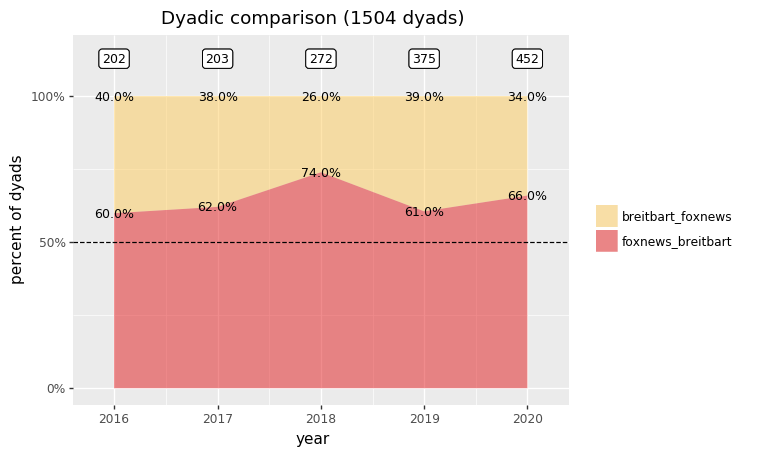

[<ggplot: (8787705148919)>]

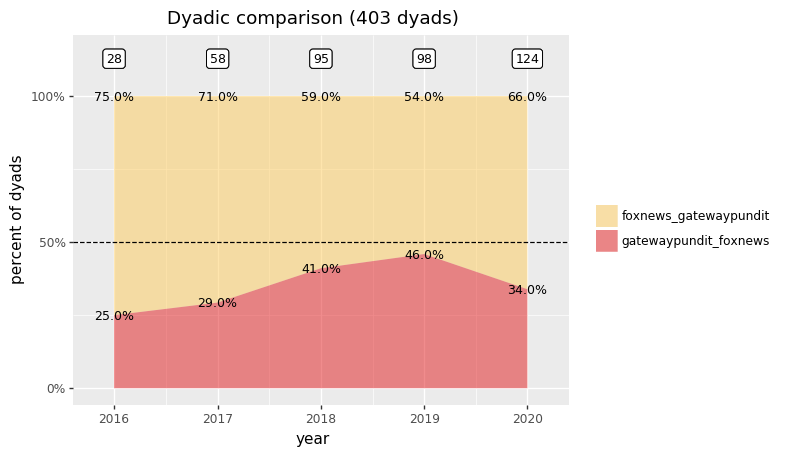

[<ggplot: (8787702533184)>]

In [28]:
# plot_filtered_yearly_dyadic_comparison():
# when values0 and values1 each have exactly 1 doctype value,
# the function returns 1 plot with both directions (displays at "doctype_to_doctype" level)

KEY0 = "doctype"
KEY1 = "doctype"
VALUES0 = ["breitbart", "gatewaypundit"] # ALT_RIGHT_DOCTYPES
VALUES1 = ["foxnews"]

for DOCTYPE in VALUES0:
    display(plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                                   key0=KEY0,
                                                   key1=KEY1,
                                                   values0=[DOCTYPE],
                                                   values1=VALUES1))

- compare selected alternative-right outlets based on their patterns as leaders

------------------------------------------------------------------------------------------------------------------------
When ['breitbart'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['breitbart']
Following doctype_ideo(s): ['alt', 'est']


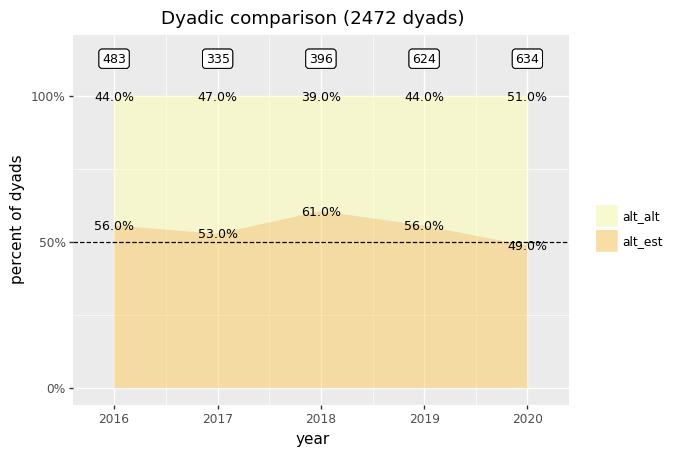

<ggplot: (8787702194854)>

------------------------------------------------------------------------------------------------------------------------
When ['gatewaypundit'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['gatewaypundit']
Following doctype_ideo(s): ['alt', 'est']


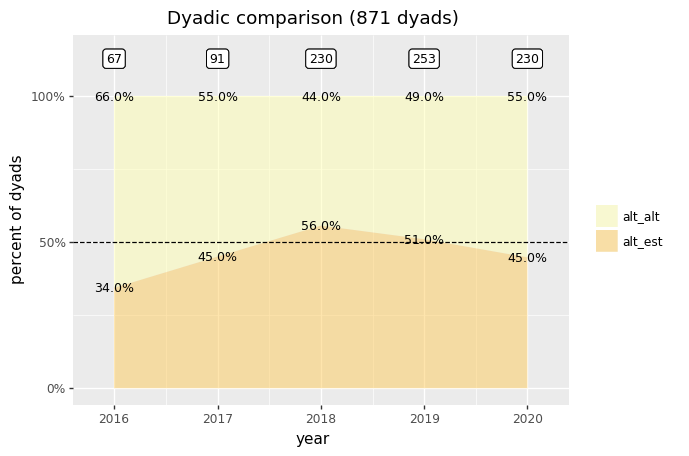

<ggplot: (8787715264211)>

------------------------------------------------------------------------------------------------------------------------
When ['newsmax'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['newsmax']
Following doctype_ideo(s): ['alt', 'est']


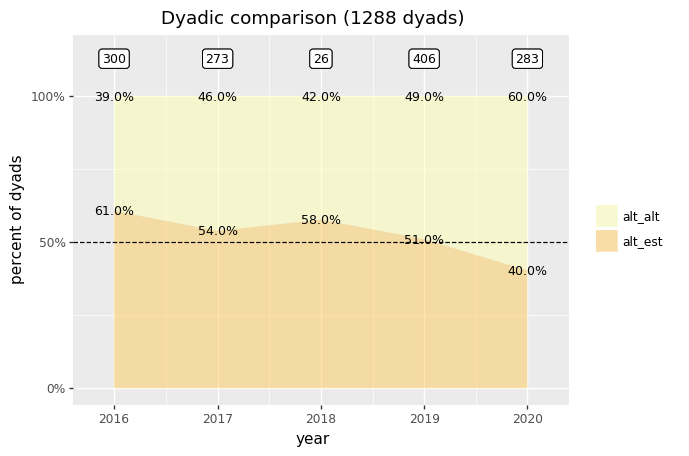

<ggplot: (8787714134230)>

------------------------------------------------------------------------------------------------------------------------
When ['oneamericanews'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['oneamericanews']
Following doctype_ideo(s): ['alt', 'est']


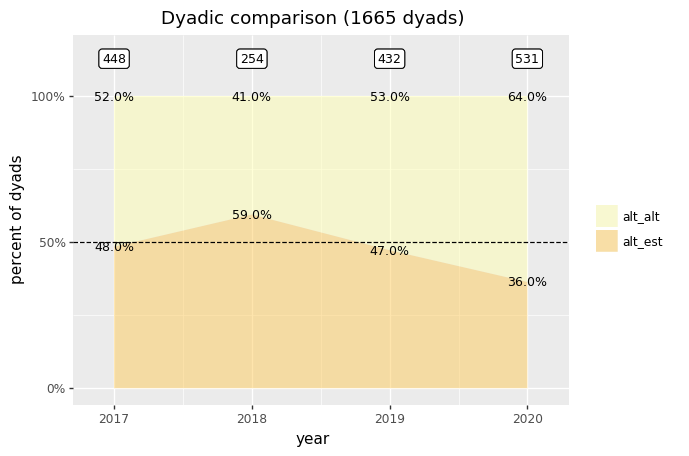

<ggplot: (8787714023397)>

In [24]:
for DOCTYPE in ["breitbart", "gatewaypundit", "newsmax", "oneamericanews"]:
    KEY0 = "doctype"
    KEY1 = "doctype_ideo"
    VALUES0 = [DOCTYPE]
    DOCTYPE0_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==VALUES0[0]]["ideo_subcategory"])[0]]
    VALUES1 = ["alt", "est"]

    plots = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                           key0=KEY0,
                                           key1=KEY1,
                                           values0=VALUES0,
                                           values1=VALUES1)

    print("-"*120)
    print(f"When {VALUES0} is a leader, it leads alternative-right outlets ({DOCTYPE0_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE0_IDEO}_est)% of the time.")
    print("-"*120)
    print(f"Leading {KEY0}(s): {VALUES0}")
    print(f"Following {KEY1}(s): {VALUES1}")
    display(plots[0])

    # print("-"*120)
    # print(f"When {VALUES0} is a follower, it follows alternative-right outlets (alt_{DOCTYPE0_IDEO})% of the time and established-right outlets (est_{DOCTYPE0_IDEO})% of the time.")
    # print("-"*120)
    # print(f"Leading {KEY1}(s): {VALUES1}")
    # print(f"Following {KEY0}(s): {VALUES0}")
    # display(plots[1])

### 5.X Archive

In [20]:
# dyadic_proportion_ideo = make_dyadic_comparison(dyads=dyads_filtered, key="doctype_ideo", version="proportion")
# # displays as percentages
# dyadic_proportion_ideo.round(decimals=3).select_dtypes(include=["number"])*100

- cycle through `EST_RIGHT_DOCTYPES`

In [21]:
# # JupyterLab has trouble displaying the plots of all doctypes in one go
# # so established-right and alternative-right in different cells

# # plot_filtered_yearly_dyadic_comparison():
# # in other cases,
# # the function returns 2 plots, one for each direction (displays at "doctype_ideo_to_doctype_ideo" level)
# for DOCTYPE in DOCTYPES:
#     if DOCTYPE in EST_RIGHT_DOCTYPES:
#         DOCTYPE_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==DOCTYPE]["ideo_subcategory"])[0]]
#         KEY0="doctype"
#         KEY1="doctype_ideo"
#         VALUES0 = [DOCTYPE]
#         VALUES1 = IDEOS.values()
        
        
#         print("="*120)
#         plots = (plot_filtered_yearly_dyadic_comparison(dyads_filtered,
#                                                key0=KEY0,
#                                                key1=KEY1,
#                                                values0=VALUES0,
#                                                values1=VALUES1))
        
#         print(f"When {DOCTYPE} is a leader, it leads alternative-right outlets ({DOCTYPE_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE_IDEO}_est)% of the time.")
#         print("-"*120)
#         # convert to list in case dict_values() are passed as values0 and/or values1
#         print(f"Leading {KEY0}(s): {list(VALUES0)}")
#         print(f"Following {KEY1}(s): {list(VALUES1)}")
#         display(plots[0])
        
#         print("-"*120)
#         print(f"When {DOCTYPE} is a follower, it follows alternative-right outlets (alt_{DOCTYPE_IDEO})% of the time and established-right outlets (est_{DOCTYPE_IDEO})% of the time.")
#         print("-"*120)
#         print(f"Leading {KEY1}(s): {list(VALUES1)}")
#         print(f"Following {KEY0}(s): {list(VALUES0)}")
#         display(plots[1])

- cycle through `ALT_RIGHT_DOCTYPES`

In [22]:
# # JupyterLab has trouble displaying the plots of all doctypes in one go
# # so established-right and alternative-right in different cells

# # plot_filtered_yearly_dyadic_comparison():
# # in other cases,
# # the function returns 2 plots, one for each direction (displays at "doctype_ideo_to_doctype_ideo" level)
# for DOCTYPE in DOCTYPES:
#     if DOCTYPE in ALT_RIGHT_DOCTYPES:
#         DOCTYPE_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==DOCTYPE]["ideo_subcategory"])[0]]
#         KEY0="doctype"
#         KEY1="doctype_ideo"
#         VALUES0 = [DOCTYPE]
#         VALUES1 = IDEOS.values()
        
        
#         print("="*120)
#         plots = (plot_filtered_yearly_dyadic_comparison(dyads_filtered,
#                                                key0=KEY0,
#                                                key1=KEY1,
#                                                values0=VALUES0,
#                                                values1=VALUES1))
        
#         print(f"When {DOCTYPE} is a leader, it leads alternative-right outlets ({DOCTYPE_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE_IDEO}_est)% of the time.")
#         print("-"*120)
#         # convert to list in case dict_values() are passed as values0 and/or values1
#         print(f"Leading {KEY0}(s): {list(VALUES0)}")
#         print(f"Following {KEY1}(s): {list(VALUES1)}")
#         display(plots[0])
        
#         print("-"*120)
#         print(f"When {DOCTYPE} is a follower, it follows alternative-right outlets (alt_{DOCTYPE_IDEO})% of the time and established-right outlets (est_{DOCTYPE_IDEO})% of the time.")
#         print("-"*120)
#         print(f"Leading {KEY1}(s): {list(VALUES1)}")
#         print(f"Following {KEY0}(s): {list(VALUES0)}")
#         display(plots[1])

<hr>

## Dev version

### 1. Load/filter dataframe of multi-article clusters

In [23]:
df_clusters_dev = load_multi_doc_clusters_only(df_dir, "softcos09_dev")
df_clusters_dev = df_clusters_dev.loc[df_clusters_dev["cluster_id"].isin(
    ["softcos09_0",
     "softcos09_1",
     "softcos09_1018",
     "softcos09_8",
     "softcos09_1019"])].reset_index(drop=True)

df_clusters_dev["doctype"] = df_clusters_dev["doc_id"].map(lambda d: extract_doctype(d))
df_clusters_dev["doctype_ideo"] = df_clusters_dev["doctype"].map(lambda d: get_ideo_subcategory(d))
df_clusters_dev["doc_topic"] = df_clusters_dev["doc_id"].map(lambda d: get_doc_topic(d))

# more efficient to query all doc_ids together than to send an HTTP request to ES for each doc_id.
# store the retrieved data in a helper dataframe (df_topics, df_tw) which is then used to populate df_clusters.

# TODO
# df_topic_dev = get_field_value_for_ids(list(df_clusters_dev["doc_id"]), "topic")
# df_clusters_dev["doc_topic"] = df_clusters_dev["doc_id"].map(lambda d: df_topic_dev.at[d, "topic"])

df_tw_dev = get_field_value_for_ids(list(df_clusters_dev["doc_id"]), "tweets2_url_ids")
df_clusters_dev["doc_tw"] = df_clusters_dev["doc_id"].map(lambda d: df_tw_dev.at[d, "tweets2_url_ids"])

df_clusters_dev_filtered = filter_clusters(
                            df_clusters_dev,
                            rmv_docs_with_odd_publish_date_ind=True,
                            filters={"years": [],
                                     "topics": []}
                        )

100%|██████████| 19/19 [00:00<00:00, 1190.64it/s]


`rmv_docs_with_odd_publish_date_ind=True`: only keep a document if it is not published at exactly 05:00 UTC (midnight EST)
- `softcos09_0`: first 2 docs are odd -> first 2 docs are removed
- `softcos09_1`: no docs are odd -> no docs removed
- `softcos09_1018`: first doc is odd -> first doc is removed
- `softcos09_8`: all docs are odd -> all docs removed
- `softcos09_1019`: non-first doc is odd -> no docs removed

`filters, years`: keep the cluster if its first document was published in one of the specified years

`filters, topics`: keep the cluster if its first document was assigned one of the specified topics